<a href="https://colab.research.google.com/github/gemdata0/Natural-Language-Processing-with-Disaster-Tweets/blob/main/Disaster_Management_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/nlp-getting-started/overview

In [119]:
import pandas as pd 
import numpy as np 
import string 

import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [120]:
data = pd.read_csv('train.csv')
data_1 = pd.read_csv('train.csv')
data.drop(['keyword', 'location'], axis = 1, inplace = True)
data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


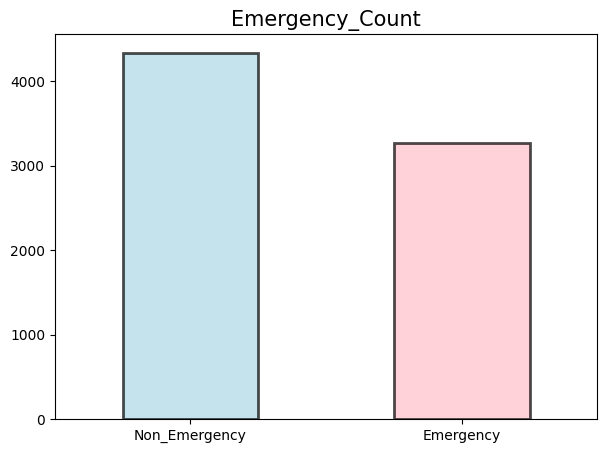

In [121]:
fig, axes = plt.subplots(figsize = (7,5))
plt.title('Emergency_Count', size = 15)
colors = ['lightblue', 'pink']
data_1['target'].replace({0: 'Non_Emergency', 1: 'Emergency'}, inplace = True)
data_1['target'].value_counts().plot(kind = 'bar', linewidth = 2, edgecolor = 'black', alpha = 0.7, color = colors)
plt.xticks(rotation = 0);

# There is no class imbalance.
# This is good for prediction.

In [122]:
# Cleaning the data.
data['text'] = data['text'].astype(str).str.replace('[{}]'.format(string.punctuation), '', regex = True) # Removing punctuations 
data['text'] = data['text'].astype(str).str.lower() # Making lower case
corpus = data['text'].astype(str).str.cat().split('\n') # Concatinating and splitting sentences
for i in range(len(corpus)):
  corpus[i] = corpus[i].rstrip() # Removing white spaces
corpus = [i for i in corpus if i != '']

In [123]:
# Listing the tweets 
sentences = data['text'].to_list()
labels = data['target'].to_list()

In [128]:
# Creating subwords and saving them in a file 
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length = 5)
tokenizer.save_to_file('tokenized')

In [40]:
# Replacing the sentences with the created subwords 
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [41]:
# Changing sentences to sequences 
max_length = 50
padded_sequences = pad_sequences(sentences, maxlen = max_length, padding = 'post', truncating = 'post')

# Splitting to train and test data
training_len = int(len(sentences) * 0.8)

training_sequences = padded_sequences[0:training_len]
testing_sequences = padded_sequences[training_len:]
training_labels = labels[0:training_len]
testing_labels = labels[training_len:]

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [42]:
# Creating the models, fitting and plotting performance

embedding_dim = 16
learning_rate = 0.0003
num_epochs = 30

**Embedding**

In [43]:
model_embedding = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_embedding.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 6)                 102       
                                                                 
 dense_16 (Dense)            (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_embedding.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
history = model_embedding.fit(training_sequences, training_labels_final, epochs = num_epochs, validation_data = (testing_sequences, testing_labels_final))

Epoch 1/30
191/191 [==============================] - 12s 55ms/step - loss: 0.4244 - accuracy: 0.8374 - val_loss: 0.5590 - val_accuracy: 0.7531
Epoch 2/30
191/191 [==============================] - 3s 16ms/step - loss: 0.4216 - accuracy: 0.8378 - val_loss: 0.5609 - val_accuracy: 0.7597
Epoch 3/30
191/191 [==============================] - 2s 9ms/step - loss: 0.4190 - accuracy: 0.8368 - val_loss: 0.5576 - val_accuracy: 0.7551
Epoch 4/30
191/191 [==============================] - 1s 8ms/step - loss: 0.4167 - accuracy: 0.8376 - val_loss: 0.5577 - val_accuracy: 0.7538
Epoch 5/30
191/191 [==============================] - 1s 6ms/step - loss: 0.4143 - accuracy: 0.8363 - val_loss: 0.5573 - val_accuracy: 0.7525
Epoch 6/30
191/191 [==============================] - 1s 6ms/step - loss: 0.4125 - accuracy: 0.8371 - val_loss: 0.5575 - val_accuracy: 0.7518
Epoch 7/30
191/191 [==============================] - 2s 9ms/step - loss: 0.4107 - accuracy: 0.8369 - val_loss: 0.5581 - val_accuracy: 0.7538
Epo

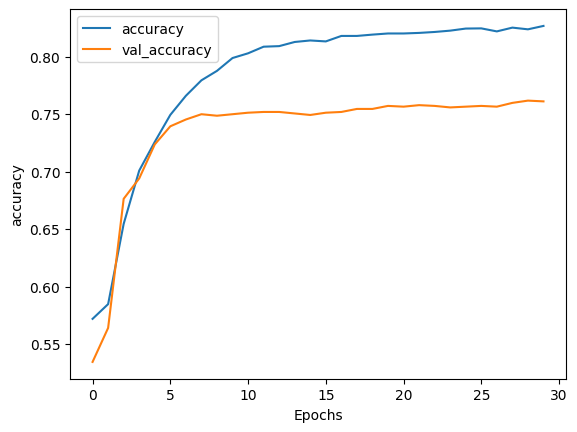

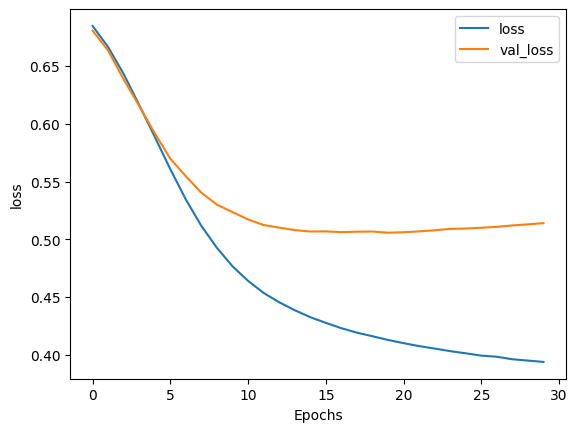

In [45]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

**CNN**

In [46]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 16)            16000     
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_17 (Dense)            (None, 6)                 102       
                                                                 
 dense_18 (Dense)            (None, 1)                 7         
                                                                 
Total params: 17,405
Trainable params: 17,405
Non-trainable params: 0
__________________________________________________

In [47]:
model_cnn.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
history = model_cnn.fit(training_sequences, training_labels_final, epochs = num_epochs, validation_data = (testing_sequences, testing_labels_final))

Epoch 1/30
191/191 [==============================] - 16s 51ms/step - loss: 0.6813 - accuracy: 0.5793 - val_loss: 0.6871 - val_accuracy: 0.5345
Epoch 2/30
191/191 [==============================] - 3s 18ms/step - loss: 0.6705 - accuracy: 0.5793 - val_loss: 0.6809 - val_accuracy: 0.5345
Epoch 3/30
191/191 [==============================] - 2s 10ms/step - loss: 0.6554 - accuracy: 0.5944 - val_loss: 0.6598 - val_accuracy: 0.5870
Epoch 4/30
191/191 [==============================] - 1s 6ms/step - loss: 0.6185 - accuracy: 0.6729 - val_loss: 0.6380 - val_accuracy: 0.6336
Epoch 5/30
191/191 [==============================] - 1s 7ms/step - loss: 0.5752 - accuracy: 0.7213 - val_loss: 0.6194 - val_accuracy: 0.6619
Epoch 6/30
191/191 [==============================] - 1s 6ms/step - loss: 0.5317 - accuracy: 0.7519 - val_loss: 0.6061 - val_accuracy: 0.6868
Epoch 7/30
191/191 [==============================] - 1s 8ms/step - loss: 0.4888 - accuracy: 0.7816 - val_loss: 0.5852 - val_accuracy: 0.7045
Ep

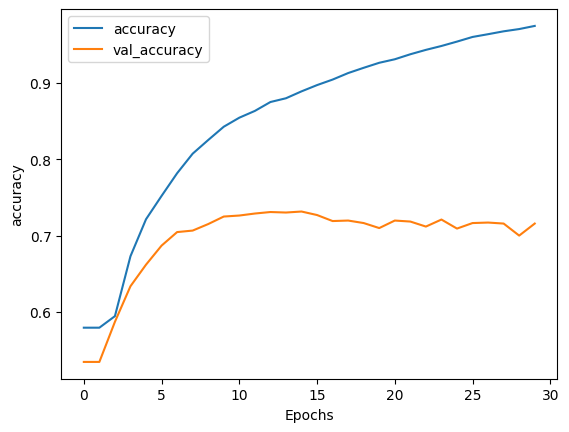

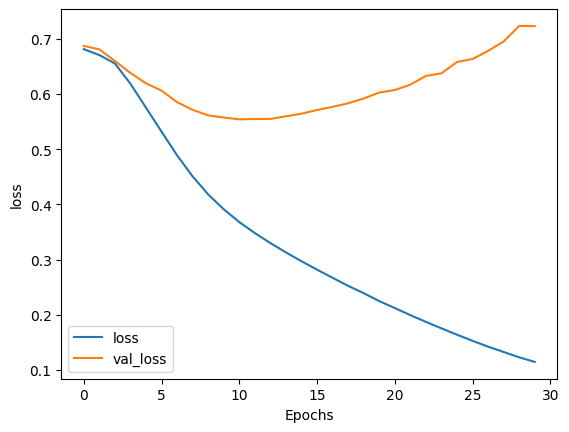

In [48]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

**GRU**

In [ ]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.summary()

In [ ]:
model_gru.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
history = model_gru.fit(training_sequences, training_labels_final, epochs = num_epochs, validation_data = (testing_sequences, testing_labels_final))

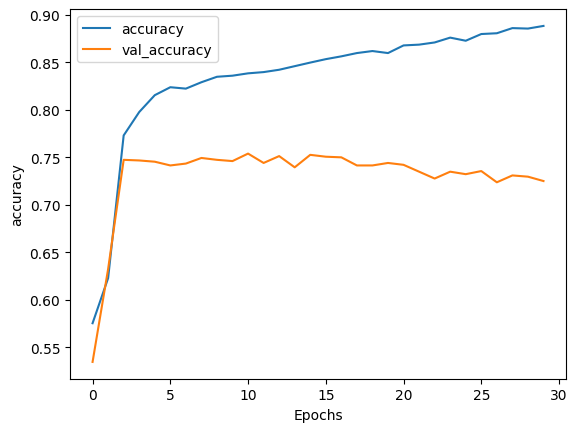

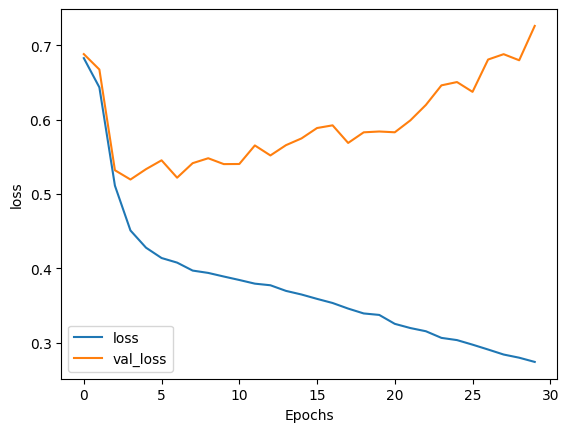

In [51]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

**Bidirectional_LSTM**

In [52]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bidi_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 16)            16000     
                                                                 
 bidirectional_8 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_21 (Dense)            (None, 6)                 198       
                                                                 
 dense_22 (Dense)            (None, 1)                 7         
                                                                 
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_bidi_lstm.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
history = model_bidi_lstm.fit(training_sequences, training_labels_final, epochs = num_epochs, validation_data = (testing_sequences, testing_labels_final))

Epoch 1/30
191/191 [==============================] - 15s 57ms/step - loss: 0.6774 - accuracy: 0.5791 - val_loss: 0.6677 - val_accuracy: 0.5345
Epoch 2/30
191/191 [==============================] - 4s 24ms/step - loss: 0.6296 - accuracy: 0.6064 - val_loss: 0.6196 - val_accuracy: 0.6796
Epoch 3/30
191/191 [==============================] - 3s 14ms/step - loss: 0.5669 - accuracy: 0.7598 - val_loss: 0.6034 - val_accuracy: 0.7367
Epoch 4/30
191/191 [==============================] - 3s 14ms/step - loss: 0.5338 - accuracy: 0.7964 - val_loss: 0.6016 - val_accuracy: 0.7367
Epoch 5/30
191/191 [==============================] - 3s 14ms/step - loss: 0.5148 - accuracy: 0.8087 - val_loss: 0.6145 - val_accuracy: 0.7269
Epoch 6/30
191/191 [==============================] - 3s 16ms/step - loss: 0.4985 - accuracy: 0.8176 - val_loss: 0.6163 - val_accuracy: 0.7328
Epoch 7/30
191/191 [==============================] - 2s 11ms/step - loss: 0.4867 - accuracy: 0.8246 - val_loss: 0.5969 - val_accuracy: 0.737

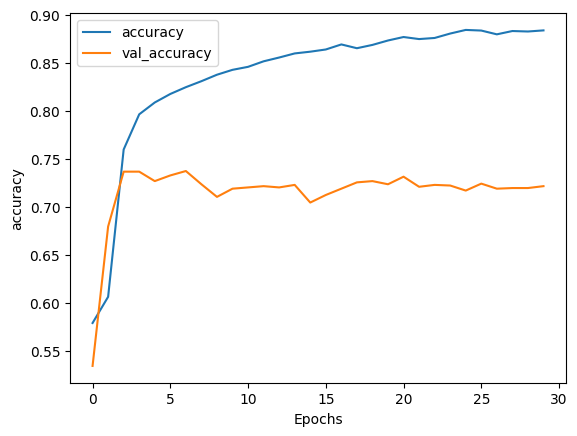

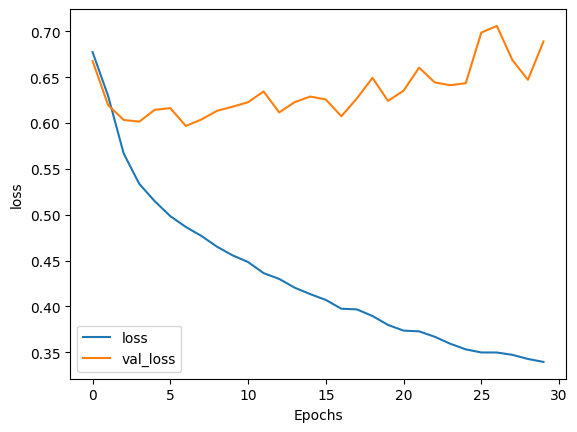

In [54]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

**Multiple_Bidirectional LSTM**

In [55]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_multiple_bidi_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 16)            16000     
                                                                 
 bidirectional_9 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 6)                 198       
                                                                 
 dense_24 (Dense)            (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-tra

In [72]:
model_multiple_bidi_lstm.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
history = model_multiple_bidi_lstm.fit(training_sequences, training_labels_final, epochs = 50, validation_data = (testing_sequences, testing_labels_final))

Epoch 1/50
191/191 [==============================] - 21s 69ms/step - loss: 0.2569 - accuracy: 0.9202 - val_loss: 0.7180 - val_accuracy: 0.7301
Epoch 2/50
191/191 [==============================] - 6s 29ms/step - loss: 0.2511 - accuracy: 0.9218 - val_loss: 0.7726 - val_accuracy: 0.7321
Epoch 3/50
191/191 [==============================] - 4s 21ms/step - loss: 0.2510 - accuracy: 0.9212 - val_loss: 0.7566 - val_accuracy: 0.7288
Epoch 4/50
191/191 [==============================] - 3s 18ms/step - loss: 0.2511 - accuracy: 0.9202 - val_loss: 0.8049 - val_accuracy: 0.7229
Epoch 5/50
191/191 [==============================] - 4s 21ms/step - loss: 0.2499 - accuracy: 0.9187 - val_loss: 0.7866 - val_accuracy: 0.7301
Epoch 6/50
191/191 [==============================] - 3s 16ms/step - loss: 0.2388 - accuracy: 0.9250 - val_loss: 0.7791 - val_accuracy: 0.7315
Epoch 7/50
191/191 [==============================] - 3s 15ms/step - loss: 0.2382 - accuracy: 0.9238 - val_loss: 0.7826 - val_accuracy: 0.729

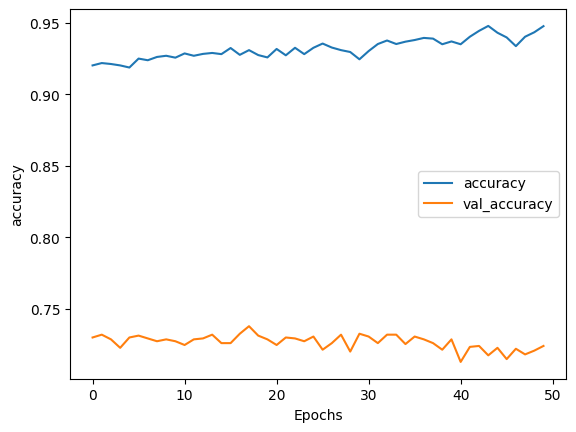

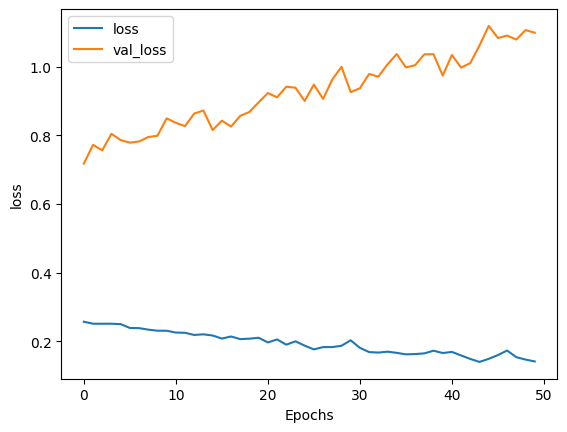

In [75]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#**Testing**

In [76]:
data_t = pd.read_csv('test.csv')
data_t.drop(['keyword', 'location'], axis = 1, inplace = True)
data_t.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [77]:
data_t['text'] = data_t['text'].astype(str).str.replace('[{}]'.format(string.punctuation), '', regex = True)
data_t['text'] = data_t['text'].astype(str).str.lower()
corpus = data_t['text'].astype(str).str.cat().split('\n')
for i in range(len(corpus)):
  corpus[i] = corpus[i].rstrip()
corpus = [i for i in corpus if i != '']

In [78]:
sentences_t = data_t['text'].to_list()

In [79]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences_t, vocab_size, max_subword_length = 5)

In [80]:
for i, sentence_t in enumerate(sentences_t):
  sentences_t[i] = tokenizer.encode(sentence_t)

In [81]:
padded_sentences_t = pad_sequences(sentences_t, maxlen = max_length, padding = 'post', truncating = 'post')

In [88]:
prediction_embedding = model_embedding.predict(padded_sentences_t)
prediction_cnn = model_cnn.predict(padded_sentences_t)
prediction_gru = model_gru.predict(padded_sentences_t)
prediction_bidi_lstm = model_bidi_lstm.predict(padded_sentences_t)
prediction_multi_biderectional_lstm =  model_multiple_bidi_lstm.predict(padded_sentences_t)

102/102 [==============================] - 2s 5ms/step


In [110]:
prediction_embedding = pd.DataFrame(np.round(prediction_embedding))
prediction_cnn = pd.DataFrame(np.round(prediction_cnn))
prediction_gru = pd.DataFrame(np.round(prediction_gru))
prediction_bidi_lstm = pd.DataFrame(np.round(prediction_bidi_lstm))
prediction_multi_bidirectional_lstm = pd.DataFrame(np.round(prediction_multi_biderectional_lstm))

In [113]:
data_t['prediction_embedding'] = prediction_embedding
data_t['prediction_cnn'] = prediction_cnn
data_t['prediction_gru'] = prediction_gru
data_t['prediction_bidi_lstm'] = prediction_bidi_lstm
data_t['prediction_multi_bidirectional_lstm'] = prediction_multi_bidirectional_lstm

In [114]:
data_t.head()

,id,text,prediction,prediction_embedding,prediction_cnn,prediction_gru,prediction_bidi_lstm,prediction_multi_bidirectional_lstm
0,0,just happened a terrible car crash,0.0,1.0,0.0,0.0,1.0,1.0
1,2,heard about earthquake is different cities sta...,0.0,0.0,0.0,0.0,0.0,0.0
2,3,there is a forest fire at spot pond geese are ...,0.0,0.0,0.0,0.0,0.0,0.0
3,9,apocalypse lighting spokane wildfires,0.0,0.0,0.0,0.0,0.0,0.0
4,11,typhoon soudelor kills 28 in china and taiwan,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
data_t.to_excel(r'C:\Users\USER\Desktop\projects\Kaggle\Disaster Management\prediction.xlsx', index = False)